### Necessary Imports and Installs

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, \
BatchNormalization, Normalization, Dropout, Flatten, Lambda, Input, Activation, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import Callback, LambdaCallback
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import scale
import time
import random
from collections import defaultdict
import math
import copy
import threading
import opendatasets as od
import tempfile
from sklearn.utils import shuffle

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys

from GLC.data_loading.common import load_patch

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1ww88x2s because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Dataset

## Download Dataset

In [2]:
# only uncomment if you don't have the dataset stored on disk yet
# -> have your kaggle user credentials ready
#data = od.download("https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9")

## Load Dataset from file

Set path to competition dataset here.

In [3]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

Run the following two commands to verify that the data path is set correctly. They should print folder and file names.

In [4]:
ls -L $DATA_PATH

metadata/      patches-fr/  patches_sample/  rasters/
observations/  patches-us/  pre-extracted/   sample_submission.csv


In [5]:
ls $DATA_PATH/observations

observations_fr_test.csv   observations_us_test.csv
observations_fr_train.csv  observations_us_train.csv


Load the observation ids of the training dataset.

In [6]:
### Training Dataset ###
# let's load the data from file
df_obs_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))

print("Number of observations for training: {}".format(len(df_obs)))

# let's have a look at the data
df_obs.head()

Number of observations for training: 1627475


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


Load the observation ids of the test dataset.

In [7]:
### Test Dataset ###
df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


Load suggested landcover alignment (only relevant if you're using landcover data later).

In [8]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
print(df_suggested_landcover_alignment.head())
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values

   landcover_code  suggested_landcover_code suggested_landcover_label
0               0                         0              Missing Data
1               1                        11          Cultivated Crops
2               2                        11          Cultivated Crops
3               3                         6       Broad-leaved Forest
4               4                         7         Coniferous Forest


### Train/Val Split Labels
Retrieve the train/val split provided, and load the labels of the train and val set elements.

In [9]:
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Training set size: {} ({:.1%} of train observations)".format(len(y_train), len(y_train) / len(df_obs)))
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

Training set size: 1587395 (97.5% of train observations)
Validation set size: 40080 (2.5% of train observations)


**Let's have a look at the training dataset.**

In [10]:
print("=== Training Dataset ===")
print("There are {} unique labels.".format(len(np.unique(y_train))))
print("We have {:.2f} observations per label on average.".format(len(obs_id_train)/len(np.unique(y_train))))

=== Training Dataset ===
There are 17031 unique labels.
We have 93.21 observations per label on average.


In [11]:
# label_count = defaultdict(lambda: 0)

# print("counting observation ids per label ...")
# for ob in df_obs.iterrows():
#     label_count[ob[1]['species_id']] += 1
# print("done")

In [12]:
# buckets = [0, 10, 100, 500, 1000, 2000, 3000, 10000, 100000]
# buckets_counts = {0: 0, 10: 0, 100: 0, 500: 0, 1000: 0, 2000: 0, 3000: 0, 10000: 0, 100000: 0}
# buckets_labels = {0: list(), 10: list(), 100: list(), 500: list(), 1000: list(), 
#                   2000: list(), 3000: list(), 10000: list(), 100000: list()}

# for label in label_count:
#     c = label_count[label]
    
#     i = 0
#     while c > buckets[i]:
#         i += 1
#     i -= 1
        
#     #print("c: ", c)
#     #print("buckets[i]: ", buckets[i])
    
#     buckets_counts[buckets[i]] += 1
#     buckets_labels[buckets[i]].append(label)
    
# print("=== Analysis of observation ids per label in training set ===")
# print("{:<15}: # of labels that have that range amount of obs ids".format("# of obs ids"))
# print()
# for i in range(0, len(buckets)-1):
#     print("{:<15}: {amount:>4} labels".format("{lower} to {upper}".format(lower=buckets[i], upper=buckets[i+1]), 
#                                               amount=buckets_counts[buckets[i]]))

# #print(buckets_contents)

Now only retrieve the data belonging to a subset of all possible labels.

In [13]:
# ### Keep only the labels with lots of observations ###
# min_obs_count = 2000
# max_obs_count = 3000

# # obtain all relevant labels
# y_train = list()
# for b in buckets:
#     if b >= min_obs_count and b <= max_obs_count:
#         for l in buckets_labels[b]:
#             y_train.append(l)
# print("obtained all relevant labels")
            
# # obtain all corresponding obs ids
# obs_list = list()

# # iterate over a subset of the labels
# counter = 0
# for y in y_train:
#     # for each label, retrieve all corresponding observation ids
#     obs = df_obs.index[(df_obs["subset"] == "train") & (df_obs["species_id"] == y)].values
#     #print(len(obs))
#     obs_list.append(obs)
    
# # we now have a numpy array of all observation ids corresponding to this subset of labels
# obs_id_train_new = np.concatenate(obs_list)
# print("obtained all observations")

# # obtain the labels in the right order 
# y_train = df_obs.loc[obs_id_train_new]["species_id"].values

# print(len(obs_id_train_new))
# print(len(obs_id_train))

# # count how many ids exist in obs_id_train_new that don't exist in obs_id_train
# # should be 0
# print("should be 0: ", len(obs_id_train_new) - len(obs_id_train_new[np.in1d(obs_id_train_new, obs_id_train)]))

# print(len(np.unique(y_train)))
# print(np.unique(y_train))

# obs_id_train = obs_id_train_new

In [ ]:
### Kennedy's Train, Val and Test Split ###
# CHOOSE SUBSET FOR 30 Labels
label_amount = 30

import random
subset_size = 0
obs_list = list()
obs_test_list = list()
import numpy as np
# iterate over a subset of the labels
m = 0
for y in (np.unique(y_train)[:]):
    #print("in")
    # for each label, retrieve all corresponding observation ids
    obs = df_obs.index[(df_obs["species_id"] == y)]
   
    #print(len(obs))
    #print(counter)
    #print(obs)
    #print(len(obs))
    if (len(obs) >= 2000 and len(obs) <= 3000):
      t = set(df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "train")].values)
      m += len(t)
      ten_perc = int(len(t)/10)
      random.seed(3)
      test = random.sample(t, ten_perc)
      train = t-set(test)
      #print(train)
      #print("here")
      obs_test_list.append(list(test))
      obs_list.append(list(train))
      subset_size += 1
    if (subset_size >= label_amount):
      #print("break")
      break
print(m)   
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_train = np.concatenate(obs_list)
obs_id_test = np.concatenate(obs_test_list)
gps_train = np.concatenate((df_obs.loc[obs_id_train]["latitude"].values, df_obs.loc[obs_id_train]["longitude"].values))
# obtain the labels in the right order 
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_test = df_obs.loc[obs_id_test]["species_id"].values
print(y_train.size)

print()
print(y_test.size)
print(y_train[2])
print()

In [ ]:
#subset_size = 8
obs_list_1 = list()
print(y_val.size)

# iterate over a subset of the labels
counter = 0
print(y_val[0])
for y in (np.unique(y_val)[:]):
    # for each label, retrieve all corresponding observation ids
    if (y in y_train):
      v = df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "val")].values
      obs_list_1.append(v)
    
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_val = np.concatenate(obs_list_1)

# obtain the labels in the right order 
y_val = df_obs.loc[obs_id_val]["species_id"].values
gps_val = np.concatenate((df_obs.loc[obs_id_val]["latitude"].values, df_obs.loc[obs_id_val]["longitude"].values))

print(y_val.size)
print(obs_id_val == obs_id_train)

In [ ]:
train_dict_count = defaultdict(lambda: 0)
for y in y_train:
    train_dict_count[y] += 1
    
print("training: ")
for key, value in train_dict_count.items():
    print("label {:>4}: {:.2f}%".format(key, value/len(y_train)))

print()

val_dict_count = defaultdict(lambda: 0)
for y in y_val:
    val_dict_count[y] += 1
    
print("validation: ")
for key, value in val_dict_count.items():
    print("label {:>4}: {:.2f}%".format(key, value/len(y_val)))

### Remap the labels s.t. they go from 0 to n-1
(NAN fix is here)

In [ ]:
# create a map s.t. the labels will go from 0 to n-1
map_labels = dict()
i = 0
for l in np.unique(y_train):
    map_labels[l] = i
    i+=1
print(map_labels)

In [ ]:
# apply the map to the training labels
y_train_normalized = np.zeros(np.shape(y_train), dtype='int64')

for i in range(len(y_train)):
    y_train_normalized[i] = map_labels[y_train[i]]
    
# shuffle together
obs_id_train, y_train = shuffle(obs_id_train, y_train_normalized)

no_output_neurons = len(np.unique(y_train))
print("# output neurons: ", no_output_neurons)

In [ ]:
# apply the map to the validation labels
y_val_normalized = np.zeros(np.shape(y_val), dtype='int64')

for i in range(len(y_val)):
    y_val_normalized[i] = map_labels[y_val[i]]
    
# shuffle together
obs_id_val, y_val = shuffle(obs_id_val, y_val_normalized)

In [ ]:
# apply the map to the test labels
y_test_normalized = np.zeros(np.shape(y_test), dtype='int64')

for i in range(len(y_test)):
    y_test_normalized[i] = map_labels[y_test[i]]
    
# shuffle together
obs_id_test, y_test = shuffle(obs_id_test, y_test_normalized)

## Write input pipeline to load batches as we train.

### Custom Generator
Since dataset is too large to load it all into memory once, we need to load it from disk in batches as we train. Such a generator can later be passed into model.fit() instead of a train and/or validation dataset.

In [ ]:
class Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()

        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            patch = load_patch(self.obs_ids[i], DATA_PATH, data='rgb')
            X_batch.append(patch[0])
            y_batch.append(self.labels[i])

        with self.lock:
            return np.asarray(X_batch), np.array(y_batch)

# First Simple Neural Network
Let's create a first neural network as a baseline to see how it performs.

In [ ]:
# # for distributed training (that is, using multiple GPUs for data parallelization)
# # https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit
# mirrored_strategy = tf.distribute.MirroredStrategy()

In [ ]:
# returns a simple convolutional neural net
def complex_model(input_shape, learning_rate=0.1, output_neurons=46):
    
    # for distributed training
    #with mirrored_strategy.scope():
    
    model = tf.keras.models.Sequential()
    dropout_prob = 0.1
    
    random.seed(42)

    he = tf.keras.initializers.HeNormal(seed=42)
    
    # 1. Preprocessing
    # rescale inputs to distribution with mean = 0 and variance = 1
    #model.add(tf.keras.layers.Normalization())
    model.add(tf.keras.layers.Rescaling(1./255))
    #model.add(tf.keras.layers.RandomFlip("horizontal"))
    #model.add(tf.keras.layers.RandomRotation(factor=0.02))
    model.add(tf.keras.layers.RandomContrast(factor=0.1))
    model.add(tf.keras.layers.RandomCrop(input_shape[0], input_shape[1]))
    #model.add(tf.keras.layers.RandomZoom(-0.1, 0.1))

    # 2. Convolutional Layers
    # 64 units
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', input_shape=input_shape,
                     kernel_initializer=he))
    model.add(Dropout(dropout_prob))

    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_prob))
    
    # 128 units
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(Dropout(dropout_prob))
    
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(Dropout(dropout_prob))
    
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_prob))
    
    # 256 units
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_prob))
    
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_prob))

    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='valid',
                     kernel_initializer=he))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_prob))

    
    # from convolutional layers to dense layers
    model.add(tf.keras.layers.Flatten())

    
    # 3. Dense Layers
    model.add(Dense(64, activation='relu', kernel_initializer=he))
    model.add(Dropout(dropout_prob))
    
    model.add(Dense(128, activation='relu', kernel_initializer=he))
    model.add(Dropout(dropout_prob))
    
    model.add(Dense(256, activation='relu', kernel_initializer=he))
    model.add(Dropout(dropout_prob))

    # 4. Output Layer
    model.add(Dense(output_neurons, activation='softmax'))
    
    # compire the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])
    
    return model

## Training Prep

### Settings used when parallelizing the I/O Pipeline in model.fit().

I used the setting values in the cell below for a high-cpu vm on GCP with the following specs:
- machine type: n1-highcpu-96 (96 CPU cores)
- vCPUs to core ratio: 2 vCPUs per core (making a theoretical max value for num_threads of 96 * 2 = 192)
- 4 x NVIDIA Tesla T4 GPUs

In [ ]:
# Remember to tune the learning rate accordingly.
BATCHSIZE = 64

# The maximun value for num_threads is dependent on amount of CPU cores:
# amount of CPU cores * vCPUs to core ratio = theoretical max of NUM_THREADS
NUM_THREADS = 11

# The more batches we prefetch, the less idle the GPUs will be. 
# To check GPU usage:
# 1. Run nvidia-smi -l 1 from the terminal to monitor the GPU usage during training. 
# 2. Try to get close to 100% for all GPUs by adjusting the value below (and the two above). Due to the overhead
#    from tf.distribute.MirroredStrategy(), you won't be able to consistently get 100% for all GPUs. But try to 
#    get close.
# 3. Be aware that RAM limits the amount of batches you can prefetch.
PRE_FETCH_NUM_BATCHES = int(NUM_THREADS * 100) 

### Generators
Create generators that will read training / validation data from disk during training.

In [ ]:
train_generator = Patches_Generator(obs_id_train, y_train, BATCHSIZE)
#train_gps_generator = GPS_Generator(obs_id_train, gps_train, y_train, BATCHSIZE)

In [21]:
val_generator = Patches_Generator(obs_id_val, y_val, BATCHSIZE)

### Cyclic learning rate
Tune the cyclic learning rate prior to training.

In [22]:
# code source: https://pyimagesearch.com/2019/08/05/keras-learning-rate-finder/

class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        
        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []
        
        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
        
    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        
        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return
        
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
            
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
        
    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=64, sampleSize=2048):
            
        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        
        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        
        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
        
        # train our model using Keras' fit method
        """self.model.fit(
            trainData,
            batch_size=batchSize,
            epochs=epochs,
            callbacks=[callback])"""
        
        history = self.model.fit(trainData, 
                            batch_size=batchSize,
                            epochs=epochs, 
                            steps_per_epoch=stepsPerEpoch,
                            callbacks=[callback], 
                            # for parallelization of reading from disk (I/O) pipeline
                            max_queue_size=PRE_FETCH_NUM_BATCHES, 
                            workers=NUM_THREADS, 
                            use_multiprocessing=True)
        
        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
            
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title="", show_candidates_only=True):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        
        # extract the candidate losses
        candidates = [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2]

        x_vals = list()
        y_vals = list()
        nextCandidate = 0
        
        for i in range(len(lrs)):
            if math.isclose(lrs[i], candidates[nextCandidate], rel_tol=0.09, abs_tol=0):
                x_vals.append(candidates[nextCandidate])
                y_vals.append(losses[i])
                nextCandidate += 1
            
            if nextCandidate >= len(candidates): 
                break
                
        x_vals.pop()
        y_vals.pop()
        x_vals.append(candidates[nextCandidate-1])
        y_vals.append(losses[-1])
        
        # plot the learning rate vs. loss
        if show_candidates_only:
            plt.title("10 Candidate Learning Rates")
            plt.plot(x_vals, y_vals)
        else:
            plt.title("All Analyzed Learning Rates")
            plt.plot(lrs, losses)
        
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        plt.grid()
        plt.xticks(candidates)
        
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)
            
        plt.show()

In [158]:

# # uncomment if you want to analyze which upper and lower bound for the cyclical learning rate policy to use

# ###### initialize model
# model_lr = complex_model((256, 256, 3), learning_rate=1e-9, output_neurons=no_output_neurons)

# # initialize the learning rate finder and then train with learning
# # rates ranging from 1e-10 to 1e+1
# print("[INFO] finding learning rate...")
# lrf = LearningRateFinder(model_lr)
# lrf.find(train_generator,
#          1e-15, 1e+2,
#          stepsPerEpoch=np.ceil(len(y_train)/BATCHSIZE),
#          epochs=6, 
#          batchSize=BATCHSIZE)


[INFO] finding learning rate...
Epoch 1/6
989/989 [==============================] - 158s 155ms/step - loss: 6.2518 - accuracy: 0.0355
Epoch 2/6
989/989 [==============================] - 158s 156ms/step - loss: 6.2761 - accuracy: 0.0347
Epoch 3/6
989/989 [==============================] - 163s 160ms/step - loss: 6.0520 - accuracy: 0.0341
Epoch 4/6
989/989 [==============================] - 160s 156ms/step - loss: 3.6846 - accuracy: 0.0360
Epoch 5/6
989/989 [==============================] - 107s 103ms/step - loss: 18.8239 - accuracy: 0.0381


Process Keras_worker_ForkPoolWorker-280:
Process Keras_worker_ForkPoolWorker-278:
Process Keras_worker_ForkPoolWorker-287:
Process Keras_worker_ForkPoolWorker-286:
Process Keras_worker_ForkPoolWorker-283:
Process Keras_worker_ForkPoolWorker-282:
Process Keras_worker_ForkPoolWorker-284:
Process Keras_worker_ForkPoolWorker-277:
Process Keras_worker_ForkPoolWorker-285:
Process Keras_worker_ForkPoolWorker-279:
Process Keras_worker_ForkPoolWorker-281:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in 

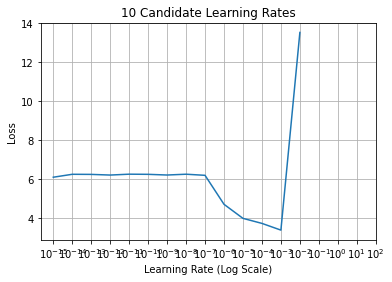

In [159]:
# plot the loss for the candidate learning rates
lrf.plot_loss()

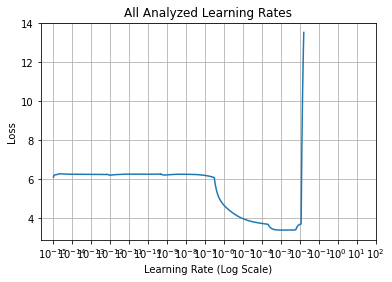

In [160]:
# plot the loss for the various learning rates
lrf.plot_loss(show_candidates_only=False)

#### From that figure identify the values of lrmin and lrmax.

I have identified them as follows:

    lr_min = 1e-7
    lr_max = 1e-3

### Training

Use the cyclical learning rate policy (with exponential decay).

In [ ]:
STEPS_PER_EPOCH = len(y_train)//BATCHSIZE

In [ ]:
# define cyclical learning rate policy
lr_min = 1e-7
lr_max = 1e-3

clr = tfa.optimizers.CyclicalLearningRate(
        initial_learning_rate=lr_min,
        maximal_learning_rate=lr_max,
        scale_fn=lambda x: 1/(2.**(x-1)), # exponential decay
        step_size=2 * STEPS_PER_EPOCH
)

Create the model.

In [ ]:
# create the network
#model = simple_model((256, 256, 3), learning_rate=clr, output_neurons=len(np.unique(y_train)))
#model = simple_model_with_gps([(256, 256, 3), np.shape(gps)], learning_rate=clr, output_neurons=len(np.unique(y_train)))

model = complex_model((256, 256, 3), learning_rate=clr, output_neurons=no_output_neurons)


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (64, 256, 256, 3)         0         
                                                                 
 random_contrast_1 (RandomCo  (64, 256, 256, 3)        0         
 ntrast)                                                         
                                                                 
 random_crop_1 (RandomCrop)  (64, 256, 256, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (64, 254, 254, 64)        1792      
                                                                 
 dropout_11 (Dropout)        (64, 254, 254, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (64, 252, 252, 64)        36928     
                                                      

Train the network.

In [30]:
tf.keras.backend.clear_session()

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=30, 
                                              verbose=0, mode='auto', baseline=None, restore_best_weights=True)


In [32]:
history = model.fit(train_generator, epochs=100, callbacks=[early_stop], #steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=val_generator,
                    # for parallelization of reading from disk (I/O) pipeline
                    max_queue_size=PRE_FETCH_NUM_BATCHES, workers=NUM_THREADS, use_multiprocessing=True)

Epoch 1/100
989/989 [==============================] - 337s 310ms/step - loss: 3.4260 - accuracy: 0.0380 - top-5-accuracy: 0.1849 - val_loss: 3.3992 - val_accuracy: 0.0410 - val_top-5-accuracy: 0.1420
Epoch 2/100
989/989 [==============================] - 136s 137ms/step - loss: 3.3978 - accuracy: 0.0384 - top-5-accuracy: 0.1902 - val_loss: 3.4014 - val_accuracy: 0.0339 - val_top-5-accuracy: 0.1480
Epoch 3/100
989/989 [==============================] - 134s 134ms/step - loss: 3.3968 - accuracy: 0.0384 - top-5-accuracy: 0.1905 - val_loss: 3.4008 - val_accuracy: 0.0339 - val_top-5-accuracy: 0.1496
Epoch 4/100
989/989 [==============================] - 137s 136ms/step - loss: 3.3569 - accuracy: 0.0579 - top-5-accuracy: 0.2118 - val_loss: 3.3686 - val_accuracy: 0.0628 - val_top-5-accuracy: 0.2332
Epoch 5/100
989/989 [==============================] - 137s 136ms/step - loss: 3.2327 - accuracy: 0.0952 - top-5-accuracy: 0.2926 - val_loss: 3.1923 - val_accuracy: 0.0945 - val_top-5-accuracy: 0.

Process Keras_worker_ForkPoolWorker-1476:
Process Keras_worker_ForkPoolWorker-1480:
Process Keras_worker_ForkPoolWorker-1481:
Process Keras_worker_ForkPoolWorker-1477:
Process Keras_worker_ForkPoolWorker-1483:
Process Keras_worker_ForkPoolWorker-1482:
Process Keras_worker_ForkPoolWorker-1478:
Process Keras_worker_ForkPoolWorker-1479:
Process Keras_worker_ForkPoolWorker-1484:
Process Keras_worker_ForkPoolWorker-1475:
Process Keras_worker_ForkPoolWorker-1485:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run(

In [36]:
model_file_name = 'complex_cnn_trial_clr_2'
model.save(model_file_name)

INFO:tensorflow:Assets written to: complex_cnn_trial_clr_2/assets


In [39]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open(model_file_name + '_history', 'w'))

In [37]:
tf.keras.backend.clear_session()

In [1]:
!ls

 GLC				        nathalie_2_highlytuned_cnn.ipynb
'HW3 main notebook.ipynb'	        nathalie_3_multimodal_simple.ipynb
 README.md			        nathalie_4_multimodal_complex.ipynb
 complex_cnn_final_data		        nathalie_cyclic_learning_rate.ipynb
 complex_cnn_final_data_history         nathalie_first_input_pipeline.ipynb
 download_data.py		        nathalie_simple_cnn_old.ipynb
 first_simple_model_random_3	        old_trials
 geolifeclef-2022-lifeclef-2022-fgvc9   playground.ipynb
 nathalie_1_simple_cnn.ipynb


In [8]:
# load history
import json
history_dict = json.load(open('complex_cnn_final_data_history', 'r'))
history_dict.keys()

dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])

In [7]:
history_dict['val_top-5-accuracy']

[0.14199890196323395,
 0.14800655841827393,
 0.14964500069618225,
 0.2332058995962143,
 0.33205899596214294,
 0.3779355585575104,
 0.44128891825675964,
 0.4822501242160797,
 0.46368104219436646,
 0.46313488483428955,
 0.5024576783180237,
 0.507919192314148,
 0.5013653635978699,
 0.5013653635978699,
 0.47733479738235474,
 0.47078099846839905,
 0.4598580002784729,
 0.46204259991645813,
 0.4538503587245941,
 0.4522119164466858,
 0.4467504024505615,
 0.42763516306877136,
 0.4363735616207123,
 0.4358274042606354,
 0.4325505197048187,
 0.4325505197048187,
 0.43364280462265015,
 0.42599672079086304,
 0.4210813641548157,
 0.4227198362350464,
 0.4210813641548157,
 0.42708903551101685,
 0.4210813641548157,
 0.4232659637928009,
 0.4221736788749695,
 0.4183506369590759,
 0.4216275215148926,
 0.41998907923698425,
 0.42053523659706116,
 0.41889676451683044,
 0.4183506369590759]

### Run on test dataset.


In [ ]:
test_generator = Patches_Generator(obs_id_test, y_test, BATCHSIZE)

In [ ]:
model.load_weights('complex_cnn_final_data')

In [ ]:
model.evaluate(test_generator)